In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

C:\Users\Artur\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('DATABASE/train.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
data.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
11      12          60

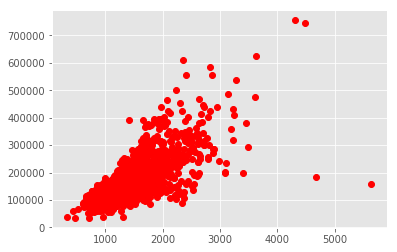

In [5]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')


In [6]:
data.describe()
    

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
def  cleaning (data):
    categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
    numerical_columns   = [c for c in data.columns if (data[c].dtype.name != 'object' and c!= 'SalePrice')]
    answer_column = [c for c in data.columns if c == 'SalePrice']
    #заполняем пустые количественные медианным значением
    data = data.fillna(data.median(axis=0), axis=0) 
    #заполняем пустые категориальные самым частым значением по признаку
    data_describe = data.describe(include=[object])
    for c in categorical_columns:                   
        data[c] = data[c].fillna(data_describe[c]['top'])
    #начинаем векторизацию - переводим категориальные признаки в количественные
    binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2] #бинарные
    nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2] #небинарные
    for c in binary_columns:
        top = data_describe[c]['top']
        top_items = data[c] == top
        data.loc[top_items, c] = 0
        data.loc[np.logical_not(top_items), c] = 1
    data_nonbinary = pd.get_dummies(data[nonbinary_columns])
    #начинаем нормализацию количественных признаков
    data_numerical = data[numerical_columns]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_answer = data[answer_column] #не требуется нормализация
    #соединяем всё в таблицу
    data = pd.concat((data_numerical, data[binary_columns], data_nonbinary, data_answer), axis=1)
    data = pd.DataFrame(data, dtype=float)
    return data

In [8]:
data  =  cleaning (data)

In [9]:
data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,1.000000,0.011156,-0.009921,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.018998,0.038920,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738,-0.021917
MSSubClass,0.011156,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.045156,-0.014555,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068,-0.084284
LotFrontage,-0.009921,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,...,0.128995,-0.023074,-0.091864,-0.021725,-0.036570,-0.018040,0.016250,-0.074146,0.127293,0.334771
LotArea,-0.033226,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635,0.263843
OverallQual,-0.028365,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.327412,-0.057962,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295,0.790982
OverallCond,0.012609,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.156175,-0.050663,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642,-0.151659,-0.077856
YearBuilt,-0.012713,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.346954,0.012122,-0.238463,-0.110233,-0.045601,-0.010104,-0.035785,-0.158427,0.343895,0.522897
YearRemodAdd,-0.021998,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.325647,-0.011431,-0.182733,-0.135942,-0.040294,-0.020727,-0.048056,-0.120577,0.322837,0.507101
MasVnrArea,-0.051071,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.165692,-0.025899,-0.128187,-0.043861,-0.011783,-0.013748,-0.009535,-0.081539,0.162205,0.472614
BsmtFinSF1,-0.005024,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.044883,0.010652,-0.024778,-0.024832,-0.014874,0.021369,0.000765,-0.019560,0.044912,0.386420


In [10]:
data.corr()['SalePrice'].abs().sort_values(ascending=False)


SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
ExterQual_TA            0.589044
FullBath                0.560664
BsmtQual_Ex             0.553105
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
KitchenQual_TA          0.519298
GarageFinish_Unf        0.513906
YearRemodAdd            0.507101
KitchenQual_Ex          0.504094
BsmtQual_TA             0.498545
Foundation_PConc        0.497734
MasVnrArea              0.472614
Fireplaces              0.466929
GarageYrBlt             0.466754
ExterQual_Gd            0.452466
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
MasVnrType_None         0.367456
SaleType_New            0.357509
          

In [11]:
#OverallQual: общая оценка - нужно
#GrLivArea: жилая площадь самого дома - нужно
#GarageCars, GarageArea - значит для покупателя одно и то же. Оставим один признак
#TotalBsmtSF: общая площадь подвала дома - Вроде нужно
#1stFlrSF: площадь 1 этажа - значим для покупателя почти так же, как и TotalBsmtSF, уберём
#ExterQual_ТА: качество внешней отделки - сильно коррелирует с ценой, нужно
#FullBath: полноценные ванные комнаты, находящиеся не в подвале , нужно
#BsmtQual_Ex: высота подвала - нужно
#TotRmsAbvGrd: кол-во комнат выше подвала - нужно
#YearBuilt: дата постройки - нужно
#KitchenQual_TA: качество кухни - нужно
#GarageFinish_Unf: качество интерьера гаража , оставим
#YearRemodAdd: ремонт - слишком сильно коррелирует с датой постройки. убираем
#KitchenQual_Ex: убираем

In [12]:
data['YearBuilt'].corr(data['YearRemodAdd'])

0.5928549763436504

In [13]:
data['GrLivArea'].corr(data['TotalBsmtSF'])

0.45486820254790306

In [14]:
data = data[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA','FullBath',
             'BsmtQual_Ex','TotRmsAbvGrd','YearBuilt','KitchenQual_TA','GarageFinish_Unf','SalePrice']]

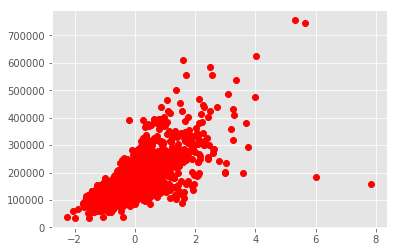

In [15]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')


In [16]:
data=data[(np.abs(stats.zscore(data)) < 3).all(axis=1)] # красиво


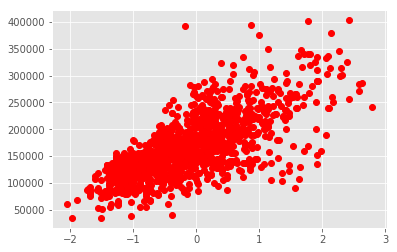

In [17]:
plt.plot(data['GrLivArea'], data['SalePrice'], 'ro')


In [18]:
x = data.drop(('SalePrice'), axis=1)  # входные фичи
y = data['SalePrice']                 # ответ

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.5, random_state = 11)

In [19]:
#Линейная регрессия
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x_train, y_train)
y_valid_predict = regr.predict(x_valid)

In [20]:
print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_valid, y_valid_predict))
print('Variance score: %.2f' % r2_score(y_valid, y_valid_predict))

Coefficients: 
 [ 1.62963484e+04  2.93660083e+04  3.61378717e+03  1.47339167e+04
 -1.30921609e+03 -3.09155582e+03 -1.22781785e-11 -2.51505332e+03
  1.02293381e+04 -1.29118300e+04 -9.83179692e+03]
MAE: 18979.82
Variance score: 0.81


In [27]:
x_test = pd.read_csv('./DATABASE/test.csv')
y_test = pd.read_csv('sample.csv')

In [28]:
x_test = cleaning(x_test)
x_test = x_test[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA','FullBath','BsmtQual_Ex','TotRmsAbvGrd',
                 'YearBuilt','KitchenQual_TA','GarageFinish_Unf']]
y_test = y_test[['SalePrice']]

In [29]:
#Делаем предсказаение и сравниваем ответы
y_test_predict = regr.predict(x_test)
print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_test, y_test_predict))
print('Variance score: %.2f' % r2_score(y_test, y_test_predict))

Coefficients: 
 [ 1.62963484e+04  2.93660083e+04  3.61378717e+03  1.47339167e+04
 -1.30921609e+03 -3.09155582e+03 -1.22781785e-11 -2.51505332e+03
  1.02293381e+04 -1.29118300e+04 -9.83179692e+03]
MAE: 48811.72
Variance score: -11.72
